#### Import / Global Vars

In [234]:
#imports section
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import cvxpy as cvx
import re, os
import matplotlib.pyplot as plt
from math import *
from datetime import datetime, date, time, timedelta
from time import sleep
from mvo_utils import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [235]:
# Global variables
log = True
refresh_pricing = False
universe = 'spy-sectors' # 'spy_sectors OR 'ark_etfs'
active_etf = None # ETF name OR None for broad market
#variables for performance analysis
frequency = "W-THU"; lb = 20 # initial value for lookback
min_gross=0.5; max_gross=1; min_w=0; max_w=0.1 # default optimization vars

#### Load sector components from hard-drive

In [236]:
# load spy sector components
# would be nice to load a JSON with configuration
ticker_map = {
    'benchmark': ['SPY'],
    'equity': ['VTI','VTV','VOE','VBR','VEA','VWO'],
    'fixed_income': ['VTIP', 'SHV', 'MUB', 'LQD', 'BNDX', 'EMB'],
    'spy-sectors': ['XLE', 'XLU', 'XLK', 'XLB', 'XLP', 'XLY', 'XLI', 'XLV', 'XLF', 'XLRE'],
    'ark-etfs': ['ARKG', 'ARKK', 'ARKQ', 'ARKW']
}

config = {
    'spy-sectors' : {
        'hold_cols': ['Symbol','Company Name', 'Index Weight'],
        'hold_format': r'holdings-spy-',
        'idx_col': 'Symbol',
        'fname': 'spy-sectors',
        'skiprows': 1
    },
    'ark-etfs' : {
        'hold_cols': ['ticker','company', 'weight(%)'],
        'hold_format': r'holdings-ark-',
        'idx_col': 'ticker',
        'fname': 'ark-etfs',
        'skiprows': 0
    }
}

hold_cols = config[universe]['hold_cols']
hold_format = config[universe]['hold_format']
idx_col = config[universe]['idx_col']
fname = config[universe]['fname']
skiprows = config[universe]['skiprows']

companies = load_components(
    companies, hold_format, hold_cols, 
    idx_col, ticker_map[universe], srows=skiprows)
print("Companies loaded:", companies.shape)
px_etfs = load_pricing(fname + '.csv', 'Date')
px_spy = load_pricing('SPY.csv', 'Date')

Companies loaded: (505, 3)
Loaded pricing for spy-sectors.csv, with shape (68, 10)
Loaded pricing for SPY.csv, with shape (68, 1)


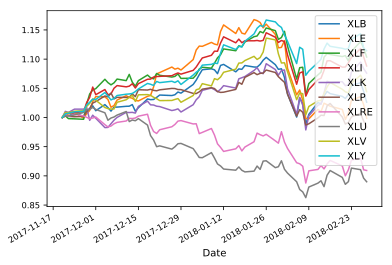

In [237]:
cpd_etf = compound(px_etfs)
cpd_etf.plot(fontsize='small') # exclude from long strat the negative sectors?

In [238]:
# Load pricing for components of each sectors
# Util function to load components for different benchmarks
def load_consol_px(tm_key):
    consol_px = pd.DataFrame([])
    for key in ticker_map[tm_key]:
        px = load_pricing(key + '-hold-pricing.csv', 'Date')[frame:].copy()
        ccols = set(consol_px.columns.tolist())
        newcols = set(px.columns.tolist())
        consol_px = consol_px.merge(
            px[list(newcols.difference(ccols))], 
            left_index=True, 
            right_index=True, 
            how='outer')
    return consol_px

consol_px = load_consol_px(universe)
if(active_etf != None):
    companies = companies[companies['ETF']==active_etf] # filter by selected ETF
tickers = companies.index.tolist()
consol_px = consol_px[list(set(tickers))]

Loaded pricing for XLE-hold-pricing.csv, with shape (68, 32)
Loaded pricing for XLU-hold-pricing.csv, with shape (68, 28)
Loaded pricing for XLK-hold-pricing.csv, with shape (68, 71)
Loaded pricing for XLB-hold-pricing.csv, with shape (68, 25)
Loaded pricing for XLP-hold-pricing.csv, with shape (68, 34)
Loaded pricing for XLY-hold-pricing.csv, with shape (68, 84)
Loaded pricing for XLI-hold-pricing.csv, with shape (68, 70)
Loaded pricing for XLV-hold-pricing.csv, with shape (68, 61)
Loaded pricing for XLF-hold-pricing.csv, with shape (68, 67)
Loaded pricing for XLRE-hold-pricing.csv, with shape (68, 33)


#### Get Data from the Server

In [239]:
# New approach using dynamic key lookup name
if refresh_pricing:
    etfs = [e for e in ticker_map[universe]]
    refresh_components(etfs)
    get_safe_pricing(universe + '.csv', ticker_map[universe], start_date)
    get_safe_pricing('SPY.csv', ['SPY'], start_date)
    px_etfs = load_pricing(universeactive_bench + '.csv', 'Date')
    px_spy = load_pricing('SPY.csv', 'Date')

#### Generate Trading Recomendations

In [240]:
# Removing tickers for M&A targets and diff class shares of same co.
remove_tickers = ['CSRA', 'DPS', 'UAA'] # example: two M&A targets, duplicate co. diff share class
if len(set(remove_tickers).intersection(consol_px.columns.tolist())) > 0:
    consol_px.drop(remove_tickers, axis=1, inplace=True)

In [241]:
# Finds the best gamma risk parameter
SAMPLES = 100
gamma_vals = np.logspace(-2, 3, num=SAMPLES)
opt_cols = ["Return", "Risk", "Sharpe"]
opt_df = pd.DataFrame([], index=gamma_vals, columns=opt_cols)

for i in gamma_vals:
    px_portion, _, alloc, pdf = recommend_allocs(
        consol_px, frame, lb, frequency, min_gross, max_gross, min_w, max_w, i)
    rec = last_allocation(alloc, 0.01)
    ret, risk = port_metrics(px_portion, rec)
    opt_df.loc[i][opt_cols] = [ret, risk, ret / risk]
top = 5; best_gamma_ports = opt_df.sort_values(by='Sharpe', ascending=False).head(top)
top_gammas = best_gamma_ports.index.tolist(); gamma_val = top_gammas[0]
portfolio_metrics('Benchmark', px_spy.loc[pdf.index]);
best_gamma_ports.head(top)

Benchmark Return: -0.04, StdDev: 0.08, Sharpe: -0.46


,Return,Risk,Sharpe
1.873817,0.0653006,0.0574757,1.13614
1.668101,0.0659871,0.0580962,1.13582
2.104904,0.0646895,0.0569843,1.13522
0.025354,0.0672494,0.0593214,1.13364
2.364489,0.0641454,0.0565964,1.13338


In [242]:
# Creates matrix of lookbacks and weights to determine the best combination
lbs = [x for x in range(5, 25, 5)]
ws = [y/100 for y in [x for x in range(5, 20, 5)]]

mtx_cols = ["Lookback", "Weight"]
mtx_cols.extend(opt_cols)
mtx_df = pd.DataFrame([], index=range(len(lbs) * len(ws)), columns=mtx_cols)

log = True; i = 0
for l in lbs:
    for w in ws:
        px_portion, _, alloc, _ = recommend_allocs(
            consol_px, frame, l, frequency, min_gross, max_gross, min_w, w, gamma_val)
        rec = last_allocation(alloc, 0.01); tickers = rec.index.tolist()
        ret, risk = port_metrics(px_portion, rec)
        mtx_df.loc[i][mtx_cols] = [l, w, ret, risk, ret / risk]
        i += 1

In [243]:
mtx_df = mtx_df.sort_values(by='Return', ascending=False)
lb, max_w = mtx_df.iloc[0]['Lookback'], mtx_df.iloc[0]['Weight']
print("Gamma: {0:.2f}, Lookback: {1}, Max Weight: {2}".format(gamma_val, lb, max_w))

Gamma: 1.87, Lookback: 20, Max Weight: 0.05


In [244]:
# what is the difference between port with gammas 1..5?
def rr_portfolios(g_list):
    best_ports = pd.DataFrame([], index=g_list)
    for g in g_list:
        _, _, alloc, _ = recommend_allocs(consol_px, frame, lb, frequency, min_gross, max_gross, min_w, max_w, g)
        rec = last_allocation(alloc, 0.01);
        df1 = pd.DataFrame(rec.T.values, index=[g], columns=rec.index.tolist())
        best_ports = best_ports.combine_first(df1)
    return best_ports
#rr_portfolios(top_gammas[:top]).T

In [245]:
# run optimization with best gamma, returns initial weights
px_portion, returns, alloc, pdf = recommend_allocs(
    consol_px, frame, lb, frequency, min_gross, max_gross, min_w, max_w, gamma_val)
rec = last_allocation(alloc, 0.01)
tickers = rec.index.tolist()
recommend = rec.copy()
cos_no_dup = companies.drop_duplicates(subset='Company')
recommend['Sector'] = cos_no_dup.loc[tickers]['ETF']
recommend['Company'] = cos_no_dup.loc[tickers][['Company']]
recommend = recommend.astype({"Allocation": np.float})
recommend[['Company', 'Sector', 'Allocation']]
recommend

,Allocation,Sector,Company
ZTS,0.050000,XLV,Zoetis Inc
EW,0.050000,XLV,Edwards Lifesciences Corp
EBAY,0.050000,XLK,eBay Inc.
IPG,0.050000,XLY,Interpublic Group Cos
ABBV,0.029984,XLV,AbbVie Inc.
MSI,0.050000,XLK,Motorola Solutions Inc
UA,0.050000,XLY,Under Armour Inc-C
BMY,0.050000,XLV,Bristol-Myers Squibb
SWKS,0.050000,XLK,Skyworks Solutions Inc
EVHC,0.050000,XLV,Envision Healthcare Corp


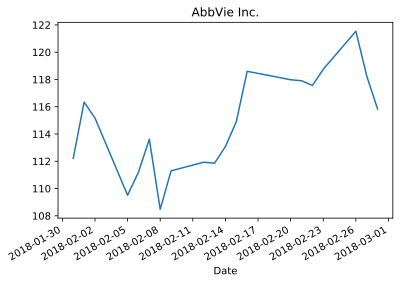

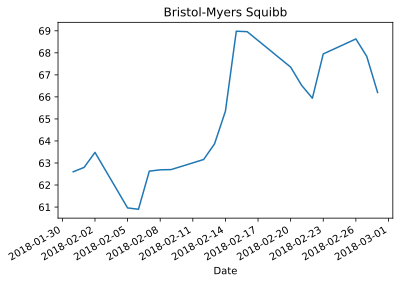

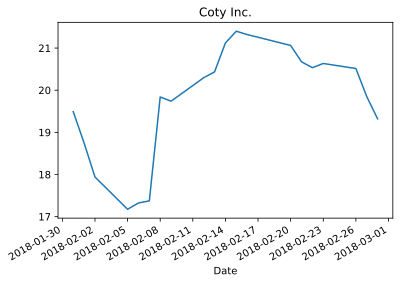

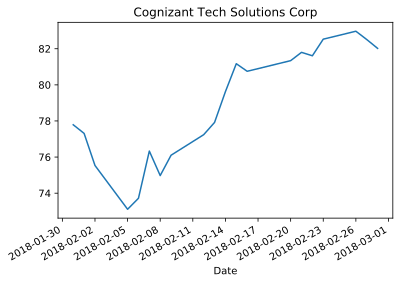

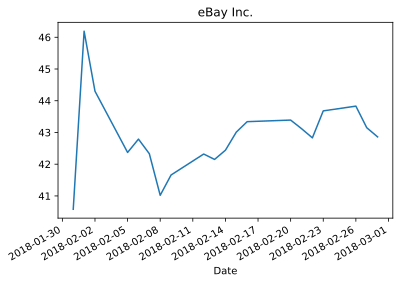

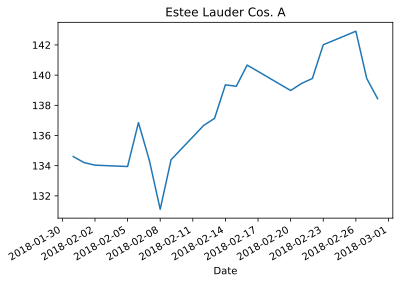

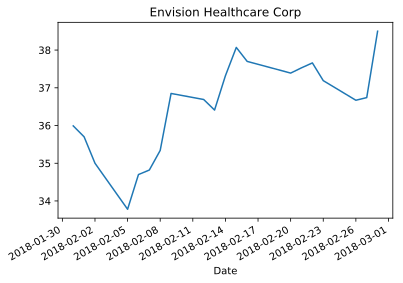

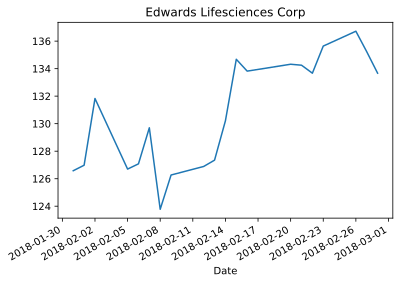

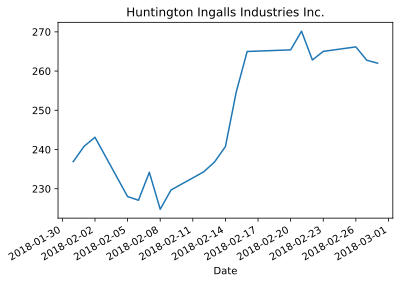

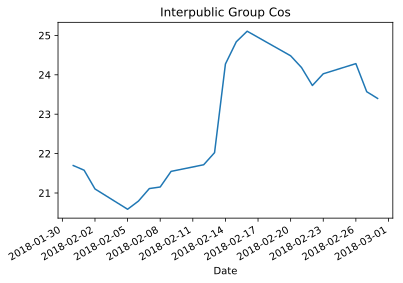

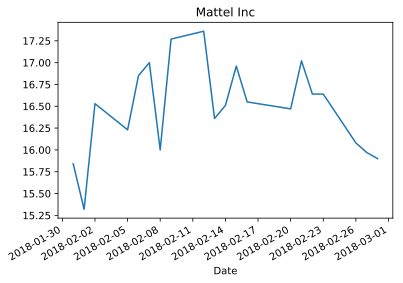

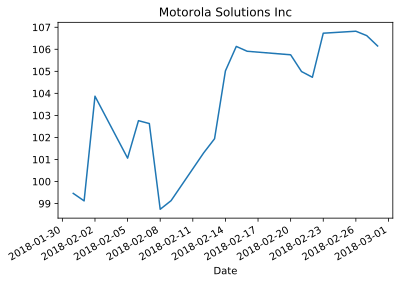

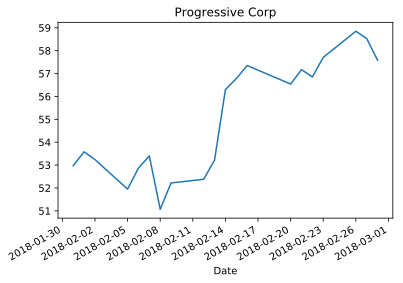

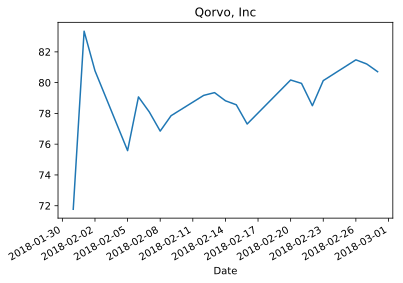

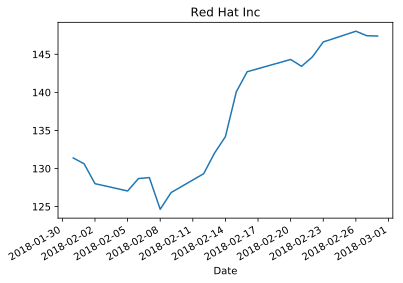

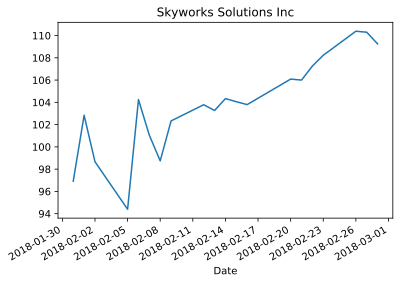

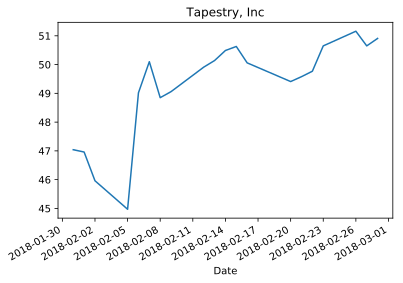

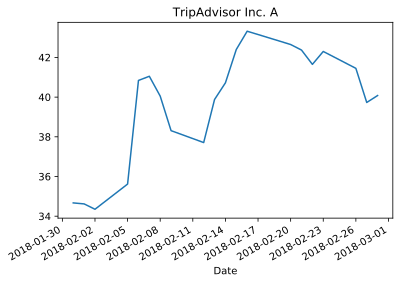

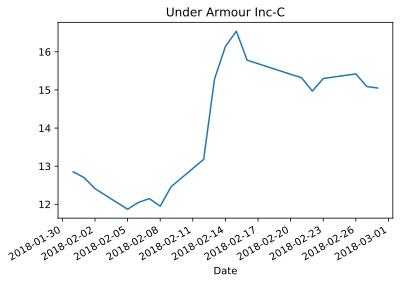

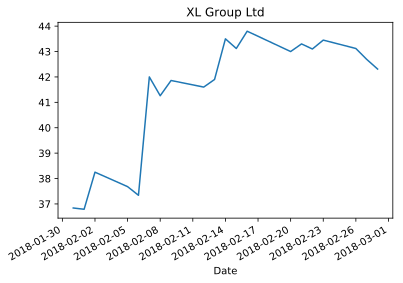

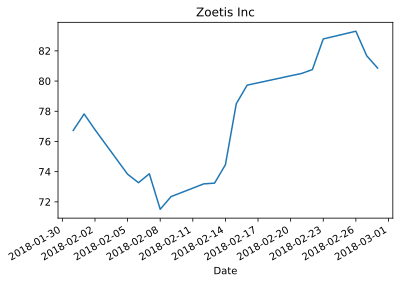

In [246]:
# plots all tickers to verify if there are any M&A targets
for t in recommend.sort_index().index:
    consol_px[t][-frame:].plot()
    plt.title(companies.loc[t]['Company'])
    plt.show()

In [247]:
def sect_group_stats(col):
    re_group = recommend.groupby(by=col)
    print("Total % Allocation {0:.2f}".format(recommend.Allocation.sum() * 100));
    sector_cols = ['Sector Weight', 'Avg Position']
    sector_df = pd.DataFrame([], index=pd.unique(recommend[col]), columns=sector_cols)
    sector_df[sector_df.columns[0]] = re_group.sum()
    sector_df[sector_df.columns[1]] = re_group.mean()
    return sector_df
sect_group_stats('Sector')

Total % Allocation 99.86


,Sector Weight,Avg Position
XLV,0.229984,0.045997
XLK,0.300000,0.050000
XLY,0.250000,0.050000
XLF,0.100000,0.050000
XLP,0.068576,0.034288
XLI,0.050000,0.050000


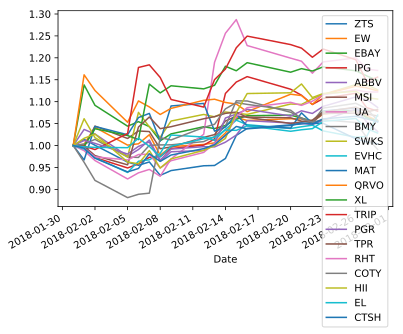

In [248]:
compound(consol_px[recommend.index][-lb:]).plot()

In [249]:
# Outputs for trade execution
px = consol_px[recommend.index][-lb:]
date = px[-1:].index.to_datetime().strftime(date_fmt)[0]
ret, risk = port_metrics(px_portion, rec) # HAS AN ISSUE HERE INCONSISTEN ***

trading_cols = ['Company', 'Price', 'Allocation', 'Dollar Value', 'Shares']
trading_df = pd.DataFrame([], index=rec.index, columns=trading_cols)

round_shares = lambda x: round(x, 0)
port_bal = 227000; alloc = rec.T.values
pvalue = (port_bal * alloc)
shares = (port_bal * alloc) / px[-1:]
shares.apply(round_shares).T.sort_index()

trading_df['Company'] = recommend['Company']
trading_df['Price'] = px[-1:].T
trading_df['Allocation'] = recommend['Allocation']
trading_df['Dollar Value'] = trading_df['Allocation'] * port_bal
trading_df['Shares'] = trading_df['Dollar Value'] / trading_df['Price']

print("Frame: {}, Lookback: {}, MinGrossAlloc: {}, MaxGrossAlloc: {}, MinWeight: {}, MaxWeight: {}".format(frame, lb, min_gross, max_gross, min_w, max_w))
print("Ann. Ret: {0:.2f}, Risk: {1:.2f} Sharpe: {2:.2f}".format(ret, risk, ret / risk))
print("Date: {0}, Total Invested: {1:.2f}, Total Allocation: {2:.2f}%".format(date, trading_df['Dollar Value'].sum(), trading_df['Allocation'].sum() * 100))

trading_df.sort_index()

Frame: 20, Lookback: 20, MinGrossAlloc: 0.5, MaxGrossAlloc: 1, MinWeight: 0, MaxWeight: 0.05
Ann. Ret: 0.10, Risk: 0.07 Sharpe: 1.34
Date: 02-28-2018, Total Invested: 226672.98, Total Allocation: 99.86%


,Company,Price,Allocation,Dollar Value,Shares
ABBV,AbbVie Inc.,115.830002,0.029984,6806.286851,58.761001
BMY,Bristol-Myers Squibb,66.199997,0.050000,11350.000000,171.450159
COTY,Coty Inc.,19.320000,0.050000,11350.000000,587.474120
CTSH,Cognizant Tech Solutions Corp,82.019997,0.050000,11349.999999,138.380888
EBAY,eBay Inc.,42.860001,0.050000,11350.000000,264.815673
EL,Estee Lauder Cos. A,138.440002,0.018576,4216.697695,30.458665
EVHC,Envision Healthcare Corp,38.500000,0.050000,11349.999999,294.805195
EW,Edwards Lifesciences Corp,133.669998,0.050000,11350.000000,84.910602
HII,Huntington Ingalls Industries Inc.,262.010010,0.050000,11350.000000,43.318956
IPG,Interpublic Group Cos,23.400000,0.050000,11350.000000,485.042735
